# Tutorial notebook for classification on extreme covariates

Implements and illustrates the methodology and theory developed in

    *  Jalalzai, H., Clémençon, S., & Sabourin, A. (2018). On binary classification in extreme regions. Advances in Neural Information Processing Systems, 31.

    * Clémençon, S., Jalalzai, H., Lhaut, S., Sabourin, A., & Segers, J. (2023). Concentration bounds for the empirical angular measure with statistical learning applications. Bernoulli, 29(4), 2797-2827.

    * Aghbalou, A., Bertail, P., Portier, F., & Sabourin, A. (2024). Cross-validation on extreme regions. Extremes, 27(4), 505-555.

## Table of Contents
* [Preliminary manipulations](#Preliminary)
* [Data generation](#Data_generation)
* [Choice of k, Episode 1.](#Choice_k_1)
* [Learning, prediction, evaluation](#Learning)
* [Choice of k: Episode 2, cross-validation](#Choice_k_2)
* [Conclusion: comparison](#conclusion)
* [Nonstandard covariates: rank-transformation ](#nonstandard)

## Preliminary manipulations <a class="anchor" id="Preliminary"></a>

In [91]:
# Set working directory if necessary
import os
# os.getcwd()
# os.chdir("../")

Imports

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.linear_model import Perceptron, LogisticRegression
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
import MLExtreme as mlx

Choose a norm function according to which 'extreme' covariates will be
selected

In [64]:
def norm_func(x):
    return np.linalg.norm(x, ord=2, axis=1)

## Data generation <a id="Data_generation"></a>

 ** Generative Model Overview **

In this toy example, each class (conditioned on $ y = 1 $ or $  y = 0 $) follows a heavy-tailed, regularly varying bivariate distribution. The tail angular measure differs from the bulk angular distribution, requiring a bias-variance trade-off when setting the training radial threshold. This threshold determines which samples are considered 'extreme', crucial for optimizing model performance in the covariates' tail.

**N.B**:  The assumptions of Jalalzai et al. (2018) are satisfied in the first part of the tutorial. In a second step we consider a setting where a  marginal transformation of the covariates is necessary, and we use the rank-transformatoin considered in Clémençon et al (2023). 

In [65]:
# data generation
Dim = 2
n = 40000
# This toy example shows gnerally improved performance of MLX models up to Dim=10. 

alpha = 2 # regular variation index of the covariate
np.random.seed(1)
# un-normalized mean angle of class 0:
mu0 = np.geomspace(1, 2**(np.sqrt(Dim)), num=Dim)
mu0 = mu0 / np.sum(mu0)
# log-concentration parameter for Dirichlet: 
lnu = np.log(1.5/mu0.min())*np.ones(Dim)
X, y = mlx.gen_classif_data_diriClasses(mu0=mu0, lnu=lnu,
                                        alpha=alpha,
                                        index_weight_noise=2*alpha,
                                        size=n)
# For more details: 
# help(mlx.gen_classif_data_diriClasses)
# in general the gap between MLX and naive depends mostly on index_weight_noise which rules how fast the tail limit structure is reached. 

In [66]:
# Choose if you wish to show graphical vizualisations of the outputs
# NB: plots are designed for the case Dim=2, interprete with care the graphical results for Dim >2
showPlots = True

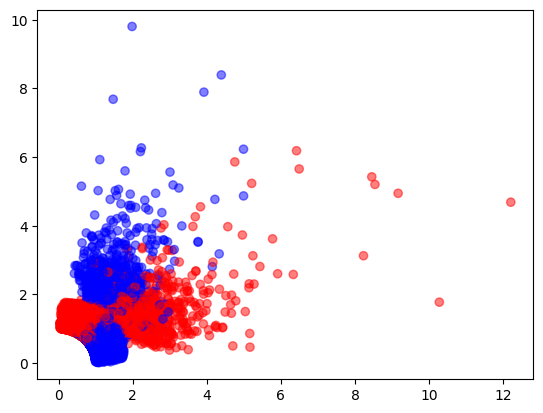

In [67]:
# Visualization of the generated data, covariates 1 and `Dim`
# (with rescaled covariates for easier visualization)

colors = np.where(y == 1, 'red', 'blue').flatten()
plt.scatter(X[:, 0]**(alpha/4), X[:, -1]**(alpha/4), c=colors, alpha=0.5)
plt.show()
# scissors-shaped pattern

In [68]:
# Splitting the data into training and test sets
# test_size: simulated data : may be set arbitrarily large upon increasing n
split = 3/4  
n_train = n * (1-split)
# n_test = n * split 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=split,
                                                    random_state=42)

## Choice of k, Episode 1. <a class="anchor" id="Choice_k_1"></a>

(For adaptive choice of k_train by cross-validation, see Episode 2 below)

To choose `k_train' the number of extreme training samples at the training step,
we suggest the following rule of thumb:

Select k_train as the largest k such that a distance covariance test [1] cannot reject the null hypothesis that the radius is independent from the pair (Angle, covariate). For small values of k, the p-value is computed by a permutation test, as justified in spirit in [2].  To avoid instabilities due to lack of moments of the radial variable, a log-transformation is applied.

Computation of the test statistics and p-values relies on the `dcor' package
https://dcor.readthedocs.io/en/stable/installation.html

Assuming `k_train` is correctly chosen,  theoretical guarantees at the
prediction test  cover in principle any `thresh_predict` such that:

` thresh_predict > np.quantiles(norm_func(X_test), 1 -  k_train/n_train) `

References
---------

[1] Székely, G. J., Rizzo, M. L., & Bakirov, N. K. (2007). Measuring and testing dependence by correlation of distances.

[2] Wan, P., & Davis, R. A. (2019). Threshold selection for multivariate heavy-tailed data. Extremes, 22(1), 131-166.

In [69]:
ratios = np.linspace(50/n_train, 0.15, num=30)
pvalues, ratio_max = mlx.test_indep_radius_rest(X_train, y_train, ratios,
                                                norm_func)

k_max = int(ratio_max * n_train)

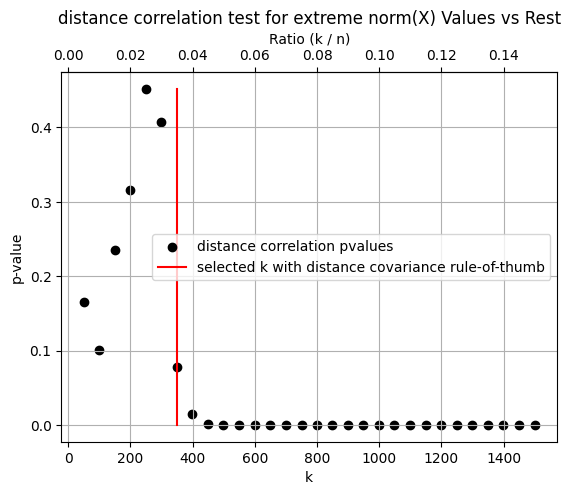

rule-of-thumb maximum admissible k (k_max): 349
rule-of-thumb maximum admissible ratio of extremes  (ratio_max):  0.035


In [70]:
# Plot the pvalues of the independence tests, and print k_max
if showPlots:
    mlx.plot_indep_radius_rest(pvalues, ratios, ratio_max, n_train)

print(f'rule-of-thumb maximum admissible k (k_max): {k_max}' )
print(f'rule-of-thumb maximum admissible ratio of extremes  (ratio_max): \
 {mlx.round_signif(ratio_max, 2)}')

In [71]:
# Set training and prediction ratios accordingly:
ratio_train = ratio_max * 4/5
ratio_test = ratio_max / 2  # higher quantile than training quantile: 
norm_X_train = norm_func(X_train)
thresh_predict = np.quantile(norm_X_train, 1-ratio_test)
thresh_train = np.quantile(norm_X_train, 1-ratio_test)
k_train = int(ratio_train * n_train)
print(f'rule-of-thumb k_train: {k_train}')

rule-of-thumb k_train: 279


## Learning, prediction, evaluation <a class="anchor" id="Learning"></a>

Choice of an off-the-shelf classification algorithm
see https://scikit-learn.org/stable/supervised_learning.html

In [72]:
# Pick a classification model in sklearn, previously imported
model = LogisticRegression()   #Perceptron()    ##RandomForestClassifier() ##LogisticRegression()   #
task = 'classification'
# Classifier class initialization
classifier = mlx.xcovPredictor(task, model, norm_func)
naive = deepcopy(model)
# Model training
threshold, ratio, X_train_extreme = classifier.fit(X_train, y_train, k_train)
naive.fit(X_train, y_train)

# Prediction on the test data above a larger threshold (extrapolation)
y_pred_extreme,  X_test_extreme, mask_test = classifier.predict(
                                            X_test, thresh_predict)

y_pred_naive = naive.predict(X_test)
y_pred_naive_extreme = y_pred_naive[mask_test]

# Performance  evaluation: Hamming loss (=0-1 loss)
y_test_extreme = y_test[mask_test]
hamming = hamming_loss(y_test_extreme, y_pred_extreme)
hamming_stdev = np.sqrt(hamming * (1-hamming)) / np.sqrt(len(y_test_extreme))
hamming_naive = hamming_loss(y_test_extreme, y_pred_naive_extreme)
hamming_naive_stdev = np.sqrt(hamming_naive * (1-hamming_naive)) / \
    np.sqrt(len(y_test_extreme))

print(f'0-1 loss MLX model (stdev):  {mlx.round_signif(hamming, 2)} \
({mlx.round_signif(hamming_stdev, 2)})')
print(f'0-1 loss naive model (stdev): {mlx.round_signif(hamming_naive, 2)} \
({mlx.round_signif(hamming_naive_stdev, 2)})')

0-1 loss MLX model (stdev):  0.094 (0.013)
0-1 loss naive model (stdev): 0.91 (0.012)


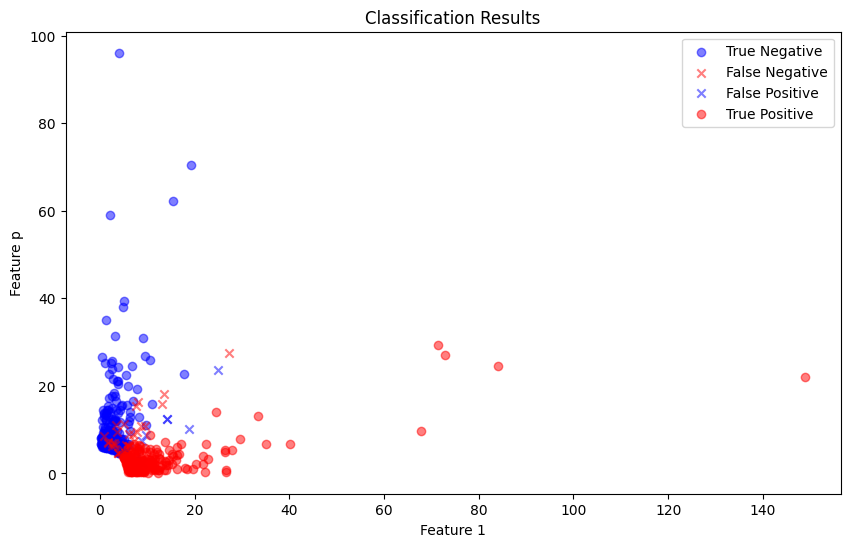

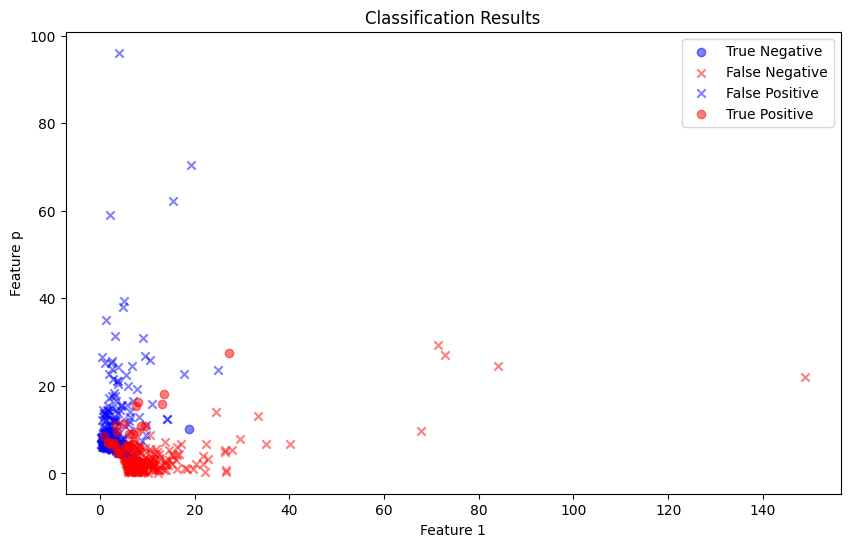

In [73]:
# Display classification results:
# on the original scale
if showPlots:
    # MLX model:
    mlx.plot_classif(X_test_extreme, y_test_extreme, y_pred_extreme)

    # naive model
    mlx.plot_classif(X_test_extreme, y_test_extreme, y_pred_naive_extreme)

## Cross-validation for model choice and choice of k <a class="anchor" id="Crossval"></a>

Two purposes are envisioned for cross-validation here:

    (a) Evaluating model performance on extremes 

    (b) choice of `k_train`, Episode 2

 ### 3.a goal:  Evaluating model performance 

In [74]:
#  Perform cross-validation  for fixed thresh_train
#  on the train set 
mean_scores, sd_mean_scores, scores = classifier.cross_validate(
    X_train, y_train, thresh_train=thresh_train, thresh_predict=thresh_predict,
    random_state=42)

print(f"CV estimated generalization risk  (error magnitude): \
{mlx.round_signif(mean_scores,2)}  ({sd_mean_scores})")
# cv estimate is reasonably close to mean core on test set. 

CV estimated generalization risk  (error magnitude): 0.076  (0.253546276418555)


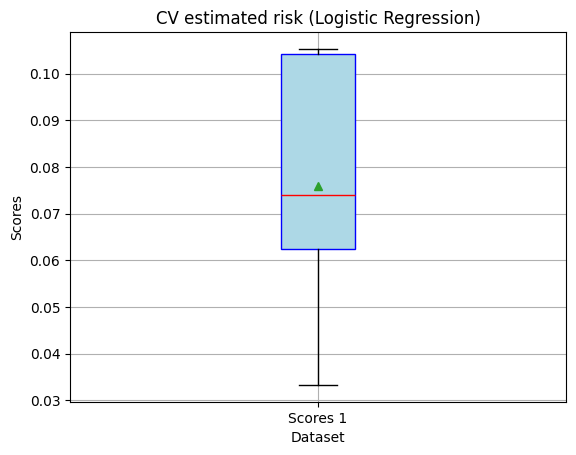

In [75]:
if showPlots: 
    plt.boxplot([scores], tick_labels=['Scores 1'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red'), showmeans=True)
    plt.xlabel('Dataset')
    plt.ylabel('Scores')
    plt.title('CV estimated risk (Logistic Regression)')
    plt.grid()
    plt.show()

### 3.b goal:  choosing the training threshold.
        (designed for a fixed prediction threshold)

In [76]:
# choose a range of training k's  (thresh_predict is defined above)
ratio_train_vect = np.linspace(0.005, 0.4, num=25)
k_train_vect = (n_train * ratio_train_vect).astype(int)
thresh_train_vect = np.array([np.quantile(norm_X_train, 1 - r)
                              for r in ratio_train_vect])

In [77]:
# compute cv scores for each value of `thresh_train`
kscores = []
kscores_sd = []
# (time consuming)
count=1
for thresh in thresh_train_vect:
    count+=1
    mean_scores, sd_mean_scores, _ = classifier.cross_validate(
        X_train, y_train, thresh_train=thresh, thresh_predict=thresh_predict,
        scoring=hamming_loss,
        random_state=42 + 103*count)
    kscores.append(mean_scores)
    kscores_sd.append(sd_mean_scores)

kscores = np.array(kscores)
kscores_sd = np.array(kscores_sd)

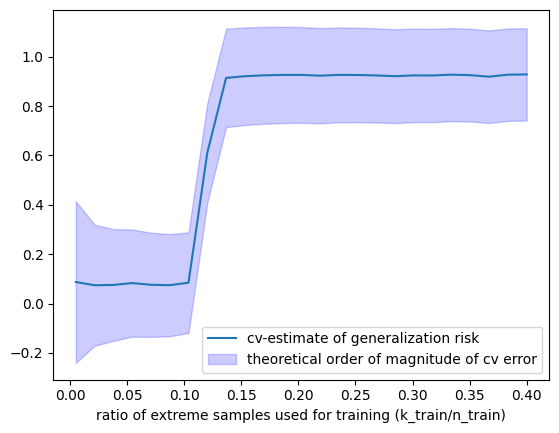

In [78]:
# plot results
if showPlots: 
    plt.plot(ratio_train_vect, kscores,label='cv-estimate of generalization risk')
    plt.fill_between(ratio_train_vect, kscores +  kscores_sd,
                     kscores -  kscores_sd, color='blue', alpha=0.2,
                     label='theoretical order of magnitude of cv error')
    plt.xlabel('ratio of extreme samples used for training (k_train/n_train)')
    plt.legend()
    plt.show()

In [79]:
i_opt = np.argmin(kscores)
k_opt = k_train_vect[i_opt]
print(f'Optimal k selected by CV: {k_opt}')
ratio_opt = ratio_train_vect[i_opt]
thresh_train_opt = thresh_train_vect[i_opt]
print(f'Optimal training ratio selected by CV: {ratio_opt}')
print(f'Maximum admissible k with rule-of-thumb: {k_max}')

Optimal k selected by CV: 214
Optimal training ratio selected by CV: 0.021458333333333336
Maximum admissible k with rule-of-thumb: 349


Improvement brought by CV?

In [80]:
# Retrain Model 2,  with k_train = k_opt and evaluate on test set
model = LogisticRegression()
classifier_cv = mlx.xcovPredictor(task, model, norm_func)
classifier_cv.fit(X_train,  y_train, k=k_opt)
# Prediction on the test data
y_pred_extreme_cv, _ , _ = classifier_cv.predict(X_test, thresh_predict)


# 0-1 loss  evaluation on extremes
y_test_extreme = y_test[mask_test]
hamming_cv = hamming_loss(y_test_extreme, y_pred_extreme_cv)
hamming_thumb = hamming
hamming_naive =  hamming_loss(y_test_extreme, y_pred_naive_extreme)

#
# Results with 0.9 confidence intervals: 

def half_ci(x):
   return  1.64*np.sqrt( x * (1-x)/ len(y_test_extreme))

print(f'hamming  MLX after cv: {hamming_cv:.4f}, \
({hamming_cv - half_ci(hamming_cv):.4f},  \
{hamming_cv + half_ci(hamming_cv):.4f})')

print(f'hamming  MLX before cv: {hamming:.4f}, \
({hamming - half_ci(hamming):.4f}, {hamming + half_ci(hamming):.4f})')

print(f'hamming  naive: {hamming_naive:.4f}, \
({hamming_naive - half_ci(hamming_naive):.4f}, \
{hamming_naive + half_ci(hamming_naive):.4f})')

hamming  MLX after cv: 0.0939, (0.0729,  0.1148)
hamming  MLX before cv: 0.0939, (0.0729, 0.1148)
hamming  naive: 0.9119, (0.8915, 0.9322)


Naive method fails.
CV and rule of thumb have similar performance. 

##  Non-standard input: Rank-transformation. <a class="anchor" id="nonstandard"></a>

(Coordinates of X may have different regular variation indices,
or even not be regularly varying at all).

For pedagogical purpose here we transform one column of X. However the rank
transformation used below is insensitive to monotonic transformation so the
results would be unchanged without this preliminary transformation.

In [81]:
# Arbitrary  (nonlinear) transformation of one component of the input
# the result in now considered as 'raw data'
X_raw = np.copy(X)
X_raw[:, 0] = np.log(1 + X[:, 0])

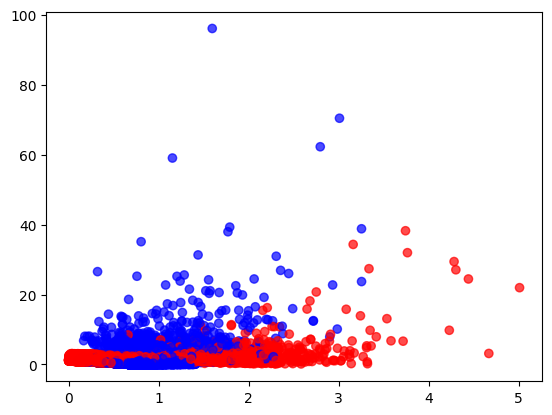

In [82]:
if showPlots:
    colors = np.where(y == 1, 'red', 'blue')
    plt.figure()
    plt.scatter(X_raw[:, 0], X_raw[:, 1], c=colors, alpha=0.7)
    plt.show()

In [83]:
# Splitting the raw data into training and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw,  y,
                                                            test_size=split,
                                                            random_state=42)

In [84]:
# rank-transform the training input into unit Pareto margins
X_train_rt = mlx.rank_transform(X_train_raw)
# learn the rank transformation on X_train and apply it to X_test
X_test_rt = mlx.rank_transform_test(x_train=X_train_raw, x_test=X_test_raw)

In [85]:
# Rule-of-thumb choice of k
ratios = np.linspace(50/n_train, 0.2, num=50) 
pvalues_rt, ratio_max_rt = mlx.test_indep_radius_rest(X_train_rt, y_train,
                                                      ratios,
                                                      norm_func)

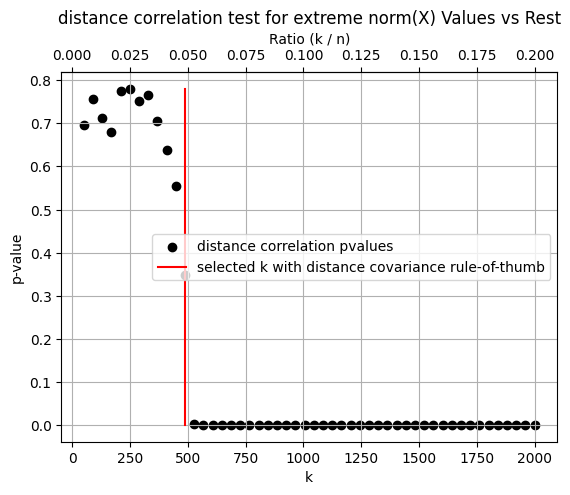

In [86]:
if showPlots:
    mlx.plot_indep_radius_rest(pvalues_rt, ratios, ratio_max_rt, n_train)

In [87]:
k_max_rt = int(ratio_max_rt * n_train)
# new rule-of-thumb k_max_rt:
print(f'rule-of-thumb k_max, rank-transformed data: {k_max_rt} ; \
ratio_max : {mlx.round_signif(ratio_max_rt, 2)}')

# previously (with standard data):
print(f'(previously) rule-of-thumb k_max, standard data: {k_max} ; \
ratio_max : {mlx.round_signif(ratio_max, 2)}')

rule-of-thumb k_max, rank-transformed data: 487 ; ratio_max : 0.049
(previously) rule-of-thumb k_max, standard data: 349 ; ratio_max : 0.035


In [88]:
# Set training and prediction ratios accordingly:
ratio_train = ratio_max_rt * 4/5
ratio_test = ratio_max_rt / 2  # higher quantile than training quantile: 
norm_X_train = norm_func(X_train_rt)
thresh_predict = np.quantile(norm_X_train, 1-ratio_test)
thresh_train = np.quantile(norm_X_train, 1-ratio_test)
k_train = int(ratio_train * n_train)
print(f'rule-of-thumb k_train, rank-transformed data: {k_train} ; ratio_train : {mlx.round_signif(ratio_train, 2)}')

rule-of-thumb k_train, rank-transformed data: 390 ; ratio_train : 0.039


In [89]:
# ### Learning on transformed inputs

# Model training on standardized data
threshold, ratio, _ = classifier.fit(X_train_rt, y_train, k=k_train)

# Prediction on the standardized test data
y_pred_extreme_rt, _ , mask_test_rt = classifier.predict(
                                            X_test_rt, thresh_predict)

# Accuracy evaluation
y_test_extreme_rt = y_test[mask_test_rt]
hamming_rt = hamming_loss(y_test_extreme_rt, y_pred_extreme_rt)
print(f'0-1 loss (with rank transformation, rule-of-thumb k): {hamming_rt:.4f}')

# recall 
print(f'0-1 loss (without rank transformation, rule-of-thumb k): \
{hamming:.4f}')

0-1 loss (with rank transformation, rule-of-thumb k): 0.0893
0-1 loss (without rank transformation, rule-of-thumb k): 0.0939


Performance similar to case 1. Rank-transformation does not significantly
alter the results.

**N.B.** The extreme train/test sets obtained with standardized data are a
priori different from the standard case.   However the proportion of
disagreements is moderate:

In [90]:
print(f' proportion of discordant selections of extremes on the test set: \
 {hamming_loss(mask_test, mask_test_rt):4f}')

 proportion of discordant selections of extremes on the test set:  0.006867
